# Regrid from CESM2 to eANT025

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
import pickle
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.interpolation import regrid_array_cf, regrid_operator_cf
from nemo_python_git.ics_obcs import fill_ocean

In [2]:
base_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

In [3]:
domcfg   = xr.open_dataset(f'{base_folder}bathymetry/domain_cfg-20240305.nc')
meshmask = xr.open_dataset(f'{base_folder}bathymetry/mesh_mask-20240305.nc')

In [14]:
climate_forcing = f'{base_folder}climate-forcing/CESM2/LE2/processed/'
cesm2_T = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_ConsTemp_y1850.nc')
cesm2_i = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_aice_y1850.nc')

In [19]:
cesm2_var = cesm2_i.isel(time=0).rename({'TLON':'lon', 'TLAT':'lat'})
cesm2_source = cesm2_var.rename({'aice':'data', 'nj':'y', 'ni':'x'})
# cesm2_source = cesm2_var.assign({'depth':cesm2_var.z_t}).rename({'ConsTemp':'data', 'nlat':'y', 'nlon':'x', 'z_t':'z'})

In [20]:
cesm2_source

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 384, x: 320)
Coordinates:
    lon      (y, x) float32 492kB ...
    lat      (y, x) float32 492kB ...
    ULON     (y, x) float32 492kB ...
    ULAT     (y, x) float32 492kB ...
    time     datetime64[ns] 8B 1850-02-01
Dimensions without coordinates: y, x
Data variables:
    data     (y, x) float32 492kB ...

In [22]:
with open('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/cf-regridding/linear-regrid-CESM2-eANT025-z0.pickle','rb') as file:
    rgo1 = pickle.load(file)
    ds_array = regrid_array_cf(cesm2_source, rgo1, key_3d=False, method='linear', src_cyclic=True, dst_cyclic=True)        

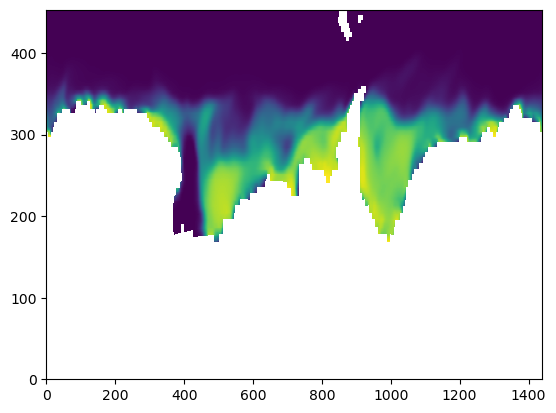

In [24]:
plt.pcolormesh(ds_array.array, vmin=0, vmax=1)

In [34]:
cesm2_pickle1 = f'{base_folder}cf-regridding/linear-regrid-CESM2-eANT025-z0-z70.pickle'
cesm2_pickle2 = f'{base_folder}cf-regridding/linear-regrid-CESM2-eANT025-z70-z121.pickle'

with open(cesm2_pickle1,'rb') as file:
    rgo1 = pickle.load(file)
    ds1  = regrid_array_cf(cesm2_source, rgo1, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)

with open(cesm2_pickle2,'rb') as file:
    rgo2 = pickle.load(file)
    ds2  = regrid_array_cf(cesm2_source, rgo2, key_3d=True, method='linear', src_cyclic=True, dst_cyclic=True)

In [35]:
ds_array = np.vstack((ds1.array, ds2.array))
ds_array_masked = xr.where(ds_array==0, np.nan, ds_array)

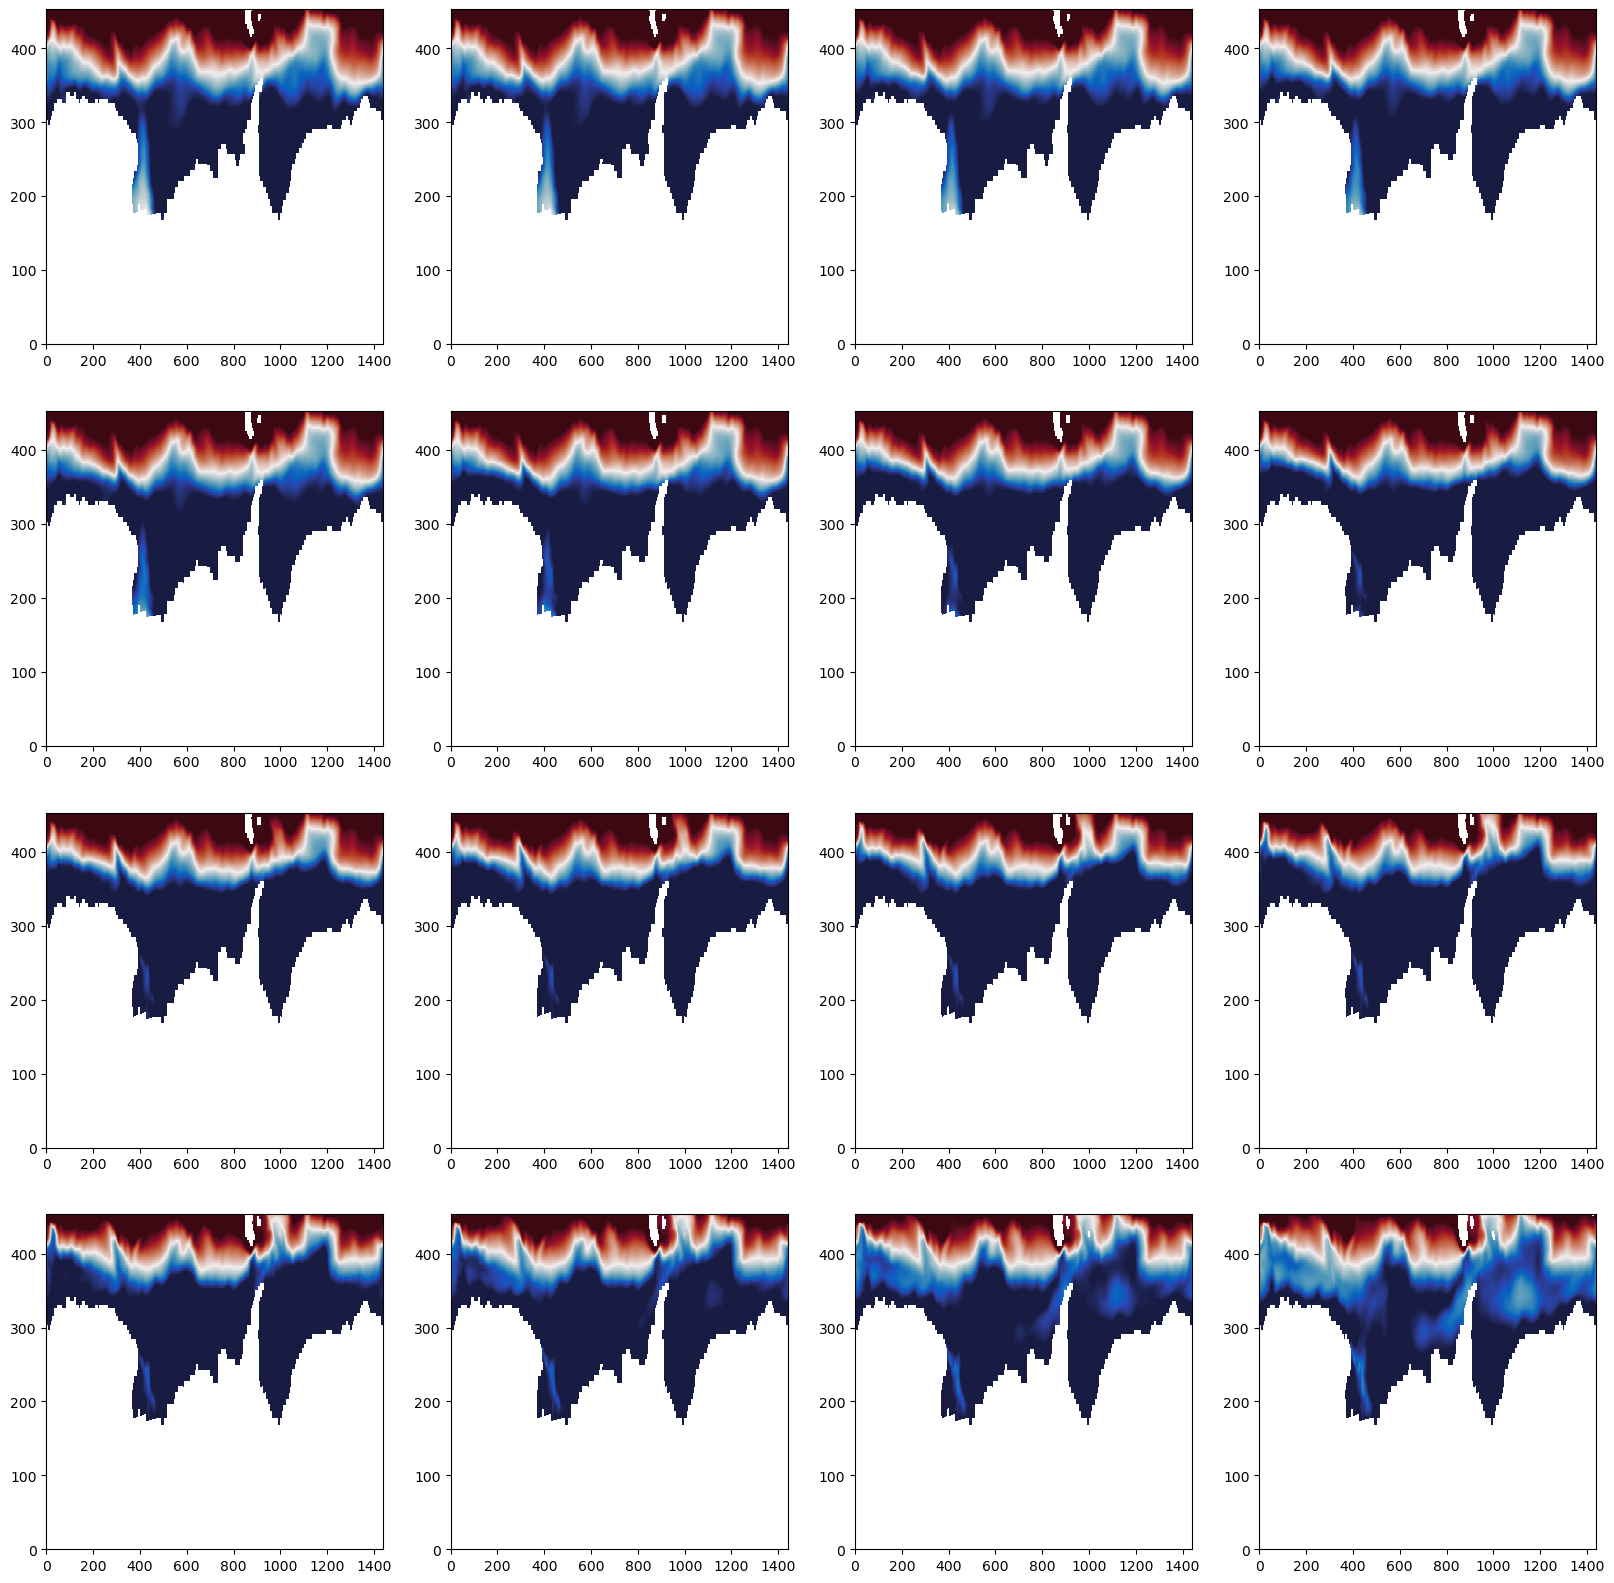

In [36]:
fig, ax = plt.subplots(4,4, figsize=(20, 20))

for n, axis in enumerate(ax.ravel()):
    img1 = axis.pcolormesh(ds_array_masked[n+10,:,:], vmin=-1, vmax=5, cmap=cmocean.cm.balance)
# plt.colorbar(ax=ax[3,0])

In [5]:
with open(f'{base_folder}cf-regridding/cesm2-regridded-filled.pickle','rb') as file:
    CESM2_extended = pickle.load(file)

In [21]:
sose_T = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/initial-conditions/SOSE-THETA-initial-conditions-20240507.nc')

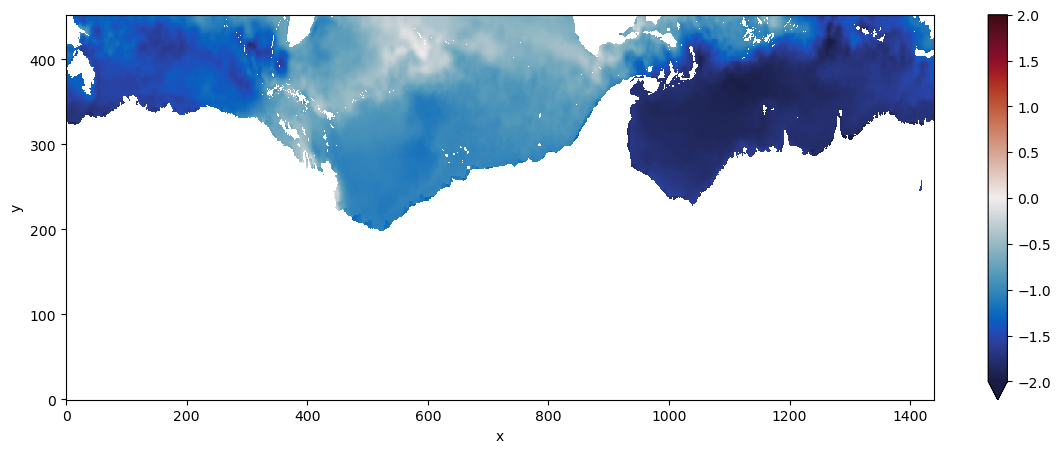

In [27]:
zind=100

(sose_T.PotTemp.isel(time_counter=0, deptht=zind) - CESM2_extended.ConsTemp.isel(z=zind)).plot(vmin=-2, vmax=2, cmap=cmocean.cm.balance, 
                                                                                       figsize=(14,5))